# Mały projekt 1: wizualizacja poziomu zanieczyszczeń (PM2.5)

Główny Inspektorat Ochrony Środowiska (GIOS) udostępnia dane o jakości powietrza w Polsce na stronie [https://powietrze.gios.gov.pl](https://powietrze.gios.gov.pl), tj. poziom stężenia pyłów PM2.5, PM10, SO2 i innych zanieczyszczeń. Dane te są szczególnie przydatne w analizach środowiskowych i zdrowotnych. W tym zadaniu interesują nas godzinne pomiary stężeń drobnego pyłu **PM2.5** (pyłu o średnicy poniżej 2.5 µm) w latach **2014, 2019 i 2024**. Pyły PM2.5 są one bardzo szkodliwe dla zdrowia, gdyż mogąc przenikać głęboko do układu oddechowego i krwiobiegu. Zadanie polega na przeprowadzeniu analizy danych wraz z opisami czynności oraz wykresami.

## Wymagania ogólne

- Rozwiązanie należy przygotować w formie **Jupyter Notebooka (`.ipynb`)**.  Rozwiązanie proszę przesłać przez Moodle’a.
- Wszystkie operacje czyszczenia i łączenia danych wykonaj **programistycznie**, bez ręcznej edycji plików.
- Do każdego punktu należy obowiązkowo dodać opis z analizą otrzymanych wyników.  
- Zadanie należy wykonać w wylosowanych parach. Obie osoby z pary przesyłają **identyczne pliki** i dodają na początku notebooka opis swojego wkładu.
- Ocena jest wspólna dla pary, a nie indywidualna.

## Dane wejściowe i metadane

- Każdy rok to archiwum ZIP dostępne pod adresem [https://powietrze.gios.gov.pl/pjp/archives/](https://powietrze.gios.gov.pl/pjp/archives/).
- Wewnątrz znajdują się pliki Excel, np. `2024_PM25_1g.xlsx`.
- Poniższa funkcja `download_gios_archive` pozwala odczytać odpowiedni zbior danych; resztę danych pomijamy.
- Użyj pliku metadanych (dostępnego na tej samej stronie), aby zaktualizować **kody stacji** (część stacji mogła w międzyczasie zmienić nazwę). W metadanych znajdziesz odpowiednie kolumny.

## Zadania

### 1. Wczytanie i czyszczenie danych

Wczytaj dane dla lat **2014, 2019 i 2024**, oczyścić je z niepotrzebnych wierszy oraz ujednolić ich format. Zaktualizuj stare kody stacji zgodnie z metadanymi. Pozostaw tylko stacje występujące we wszystkich trzech latach. Informacje o stacjach pomiarowych warto uzupełnić o miejscowości dostępne w metadanych, np. za pomocą MultiIndex: (miejscowość, kod stacji). Pomiary dokonane o północy (00:00:00) powinny być potraktowane jako dotyczące poprzedniego dnia. Połącz dane z trzech lat w jeden `DataFrame` i zapisz do pliku.

### 2. Średnie miesięczne + trend dla miast

Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla **Warszawy** i **Katowic**, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

### 3. Heatmapa miesięcznych średnich

Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

### 4. Dni z przekroczeniem normy (WHO)

Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

## Dodatkowe wymagania i sugestie

- Notebook powinien zawierać *sanity checks*, np.:
  - liczba stacji w każdym pliku,
  - liczba dni w każdym roku,  
  - kilka przykładowych mapowań kodów stacji,  
- Wszystkie wykresy powinny mieć tytuły, legendy i krótki opis interpretacji.
- Zachęcamy do weryfikacji kodu napisanego przez drugą osobę, gdyż ocena jest wspólna.
- Można wykorzystać dowolne poznane biblioteki do analizy i wizualizacji danych w Pythonie.

## Kryteria oceny

- Zadanie 1: 3 pkt
- Zadanie 2: 2 pkt
- Zadanie 3: 1.5 pkt
- Zadanie 4: 2 pkt
- Jakość wyjaśnień, interpretacje, opis wkładu: 1.5 pkt



In [ ]:
from pathlib import Path
import pandas as pd
import requests
import zipfile
import io, os


# id archiwum dla poszczególnych lat
gios_archive_url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/"
gios_url_ids = {2014: '302', 2019: '322', 2024: '582'}
gios_pm25_file = {2014: '2014_PM2.5_1g.xlsx', 2019: '2019_PM25_1g.xlsx', 2024: '2024_PM25_1g.xlsx'}

# funkcja do ściągania podanego archiwum
def download_gios_archive(year, gios_id, filename):
    # Pobranie archiwum ZIP do pamięci
    #TODO propozycja: ja bym proponował zrobione tego za pomocą path'a, bo jest czytelniej
    url = f"{gios_archive_url}{gios_id}"
    response = requests.get(url)
    response.raise_for_status()  # jeśli błąd HTTP, zatrzymaj
    
    # Otwórz zip w pamięci
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # znajdź właściwy plik z PM2.5
        #TODO 
        if not filename:
            print(f"Błąd: nie znaleziono {filename}.")
        else:
            # wczytaj plik do pandas
            with z.open(filename) as f:
                try:
                    df = pd.read_excel(f, header=None)
                except Exception as e:
                    print(f"Błąd przy wczytywaniu {year}: {e}")
    return df



In [ ]:
class GiosDataManager:
    """
    Downloads and manage GIOS data for different years and information types
    \n**df**: Dataframe based on GIOŚ data
    years
    """
    def __init__(self, years: list, informations :list):
        self.years = years
        self.informations = informations

        self._metadata = None
        self._data = None

        self._load_and_clean()

    def _load_and_clean(self):
        "Loads, cleans data, and save them in metadata and database"
        self._load_data()
        self._clean_data()

    def _load_data(self) -> None:
        """
        Downloads data from server given the years and format
        """
        #TODO - przerobić tą funkcje co oni podali, oraz pobrać metadane, 
        # TODO - ostatecznie ładujemy wszystko do _data
        # wazne żeby tutaj sprawdzić, ilość wierszy po pobraniu, (zaraz po) i po zakończeniu i sprawdzić czy się to różni) 
        self._data = ...
        self._metadata = ...
    
    def _clean_data(self) -> None:
        """
        Cleans data, merge names with newest tags 
        """
        #TODO - ta metoda będzie wywoływana
        self._data = ... 

    def save_local(self, path) -> None:
        """
        Saves loaded data locally
        """
        #TODO - zrobić funkcje która zapisuje metadane oraz dataset, w podanej ścieżce w nastepujący sposób: path/metadata + path/database
 
    def df(self) -> pd.DataFrame:
        return self._data.copy()
    

    #TODO - przepisać funkcje od zarządzania formatami 
    #TODO - wszystkie te funkcje które odpowiadają, za niektóre analizy, (jak heatmapy itd.)



In [ ]:
def clean_gios_data(df_raw: pd.DataFrame)->pd.DataFrame:
    """
    Funkcja służy do oczyszczania danych pomiarowych PM2.5 pochodzących z archiwów GIOŚ.
    Zwracany jest obiekt DataFrame z indeksem czasowym i kolumnami odpowiadającymi stacjom pomiarowym.
    """
   
    
    # Usunięcie wierszy całkowicie pustych
    df = df_raw.dropna(how='all')

    # Wykrycie pierwszego wiersza zawierającego datę 
    date_pattern = r'^\d{4}-\d{2}-\d{2}'
    start_idx = df[df.iloc[:, 0].astype(str).str.match(date_pattern, na=False)].index[0]

    # Ustawienie nazw kolumn na podstawie wiersza poprzedzającego dane (zawierającego nazwy stacji)
    df.columns = df.iloc[start_idx - 1]

    # Zachowanie tylko wierszy z rzeczywistymi pomiarami
    df = df.iloc[start_idx:].copy()

    # Zmiana nazwy pierwszej kolumny na „Data”, która zawiera daty pomiarów
    df.rename(columns={df.columns[0]: "Data"}, inplace=True)

    # Konwersja kolumny „Data” na typ datetime w celu poprawnej interpretacji czasu
    df["Data"] = pd.to_datetime(df["Data"], errors="coerce", format="%Y-%m-%d %H:%M:%S")

    # Ustawienie kolumny „Data” jako indeksu czasowego
    df.set_index("Data", inplace=True)

    # Konwersja pozostałych kolumn na wartości liczbowe
    df = df.apply(pd.to_numeric, errors="coerce")

    # Korekta godzin 00:00 – pomiary o północy przypisywane do poprzedniego dnia
    mask_midnight = df.index.hour == 0
    df.index = df.index - pd.to_timedelta(mask_midnight.astype(int), unit="D")

    return df


In [31]:
df2014_raw = download_gios_archive(2014, gios_url_ids[2014], gios_pm25_file[2014])
df2019_raw = download_gios_archive(2019, gios_url_ids[2019], gios_pm25_file[2019])
df2024_raw = download_gios_archive(2024, gios_url_ids[2024], gios_pm25_file[2024])

#df2014 = clean_gios_data(df2014_raw)
df2019 = clean_gios_data(df2019_raw)
df2024 = clean_gios_data(df2024_raw)


/home/maxi7524/.pyenv/versions/3.13.5/lib/python3.13/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [34]:
df2019

5,DsDusznikMOB-PM2.5-1g,DsJaworMOB-PM2.5-1g,DsJelGorOgin-PM2.5-1g,DsWrocAlWisn-PM2.5-1g,DsWrocWybCon-PM2.5-1g,KpBydPlPozna-PM2.5-1g,KpMogiNowMOB-PM2.5-1g,KpToruDziewu-PM2.5-1g,KpWloclOkrze-PM2.5-1g,LbLubObywate-PM2.5-1g,...,SlBielPartyz-PM2.5-1g,SlKatoKossut-PM2.5-1g,SlZlotPotLes-PM2.5-1g,WmElbBazynsk-PM2.5-1g,WmGoldUzdrowMOB-PM2.5-1g,WmOlsPuszkin-PM2.5-1g,WpKaliSawick-PM2.5-1g,ZpSzczAndr01-PM2.5-1g,ZpSzczBudzWosMOB-PM2.5-1g,ZpSzczPils02-PM2.5-1g
2019-01-01 01:00:00,33.40530,51.38780,118.77300,102.0900,107.06100,64.1177,NaN,24.0030,51.317,56.0910,...,110.1990,76.7306,26.3444,34.37060,14.9449,40.91830,75.2000,NaN,NaN,73.93500
2019-01-01 02:00:00,13.80280,28.49950,110.06400,63.6111,55.91870,43.8401,NaN,33.6542,30.698,25.9812,...,73.4132,54.4664,19.0619,23.14940,10.7420,25.93580,47.9076,NaN,NaN,11.78830
2019-01-01 03:00:00,9.94056,11.12060,107.94100,48.3540,41.34880,22.8383,NaN,13.6030,28.262,18.9462,...,50.2355,50.4599,43.7717,21.07110,12.0391,24.57250,22.8309,5.57095,NaN,8.69917
2019-01-01 04:00:00,6.75889,5.57358,94.54890,34.6621,29.86970,20.1829,NaN,17.4302,26.522,17.9144,...,37.5872,34.8090,64.0139,21.16710,13.1849,20.63360,20.5900,5.77369,NaN,5.96861
2019-01-01 05:00:00,7.88722,6.56224,67.88000,14.2870,17.60000,18.7345,NaN,23.0878,24.260,20.4470,...,22.6446,30.6517,43.6111,21.07740,14.0005,19.41940,27.0838,6.15494,NaN,7.80778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 20:00:00,18.85720,19.23390,11.92030,19.9564,10.56810,27.6000,12.0,9.9000,11.500,10.7000,...,25.3449,16.6150,12.1295,7.78593,NaN,2.90071,14.5322,34.82470,15.5959,19.16890
2019-12-31 21:00:00,25.27190,15.62100,11.81310,17.1905,8.74933,27.8000,8.9,12.9000,13.200,9.6000,...,22.5324,12.5343,10.6563,8.00023,NaN,2.91173,13.3650,30.00260,13.1825,19.71360
2019-12-31 22:00:00,37.53810,12.38820,11.39330,13.2909,8.42139,18.7000,8.5,4.7000,15.500,9.7000,...,23.8138,11.1997,13.0483,6.67999,NaN,3.08510,13.9552,27.14000,14.3764,20.24390
2019-12-31 23:00:00,29.05940,11.58090,9.02694,11.4200,8.86111,21.1000,8.4,14.0000,10.600,8.4000,...,24.4337,11.4544,11.7128,6.79077,NaN,3.75481,14.1249,24.83710,17.7941,24.74170


In [32]:
# Pierwszy wiersz ustawiony jako nagłówki kolumn  
df2014_raw.columns = df2014_raw.iloc[0]
# Usunięcie pierwszego wiersza, który został wykorzystany jako nagłówek  
df2014 = df2014_raw.drop(index=0).reset_index(drop=True)
# Zmiana nazwy pierwszej kolumny na „Data”, ponieważ zawiera daty pomiarów  
df2014.rename(columns={df2014.columns[0]: "Data"}, inplace=True)
# Usunięcie kolumn zawierających wyłącznie wartości puste  
df2014 = df2014.dropna(axis=1, how='all')
# Konwersja kolumny „Data” na typ datetime w celu umożliwienia operacji na datach  
df2014["Data"] = pd.to_datetime(df2014["Data"], errors="coerce")
# Ustawienie kolumny „Data” jako indeksu tabeli  
df2014.set_index("Data", inplace=True)
# Konwersja pozostałych kolumn (stacji pomiarowych) na wartości liczbowe  
df2014 = df2014.apply(pd.to_numeric, errors="coerce")
df2014 = df2014.iloc[2:]
df2014.head()

/tmp/ipykernel_3397117/3078082501.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2014["Data"] = pd.to_datetime(df2014["Data"], errors="coerce")


,DsWrocWisA,KpAirpWiktorowo,KpBydgPlPozn,KpBydgWarszawska,KpTorunDziewulsk,LdLodzWIOSACzernik,LdZgierzWIOSAMielcza,LuZgoraWIOS_AUT,MpKrakowWIOSAKra6117,MpKrakowWIOSBuja6119,...,SkMalogCemen3,SkPolanRuszcz,SlGliwiGliw_mewy,SlKatowKato_kossu,SlZlotyJano_lesni,WmOlsztyWIOS_Puszkin,WpWKP001,WpWKPKalisz007/10,ZpSzczecin001,ZpSzczecin002
Data,,,,,,,,,,,,,,,,,,,,,
2014-01-01 01:00:00,152.0,104.56,116.214424,140.857376,52.4172,81.029259,119.696114,NaN,104.0,78.0,...,34.12,56.54,188.0,104.0,32.0,84.121582,56.1,NaN,105.4890,109.0
2014-01-01 02:00:00,137.0,94.30,NaN,121.629723,NaN,210.364670,70.337502,NaN,104.0,65.0,...,34.61,35.93,130.0,107.0,39.0,75.444382,55.2,82.5,149.7970,118.0
2014-01-01 03:00:00,129.0,102.48,NaN,59.189041,46.5652,66.425789,40.915695,NaN,91.0,63.0,...,33.58,34.36,138.0,114.0,43.0,34.427513,49.9,83.0,86.9602,120.0
2014-01-01 04:00:00,129.0,102.32,NaN,58.038334,45.8128,53.999668,37.817917,NaN,89.0,59.0,...,31.37,35.21,171.0,108.0,42.0,32.742474,52.0,73.1,74.8762,104.0
2014-01-01 05:00:00,105.0,88.73,NaN,59.658134,45.8128,52.239670,38.814861,NaN,83.0,56.0,...,32.27,35.54,163.0,88.0,40.0,32.714367,63.4,74.9,61.9866,96.0


In [35]:
# TODO - to można dać do wcześniejszych funkcji, 
meta = pd.read_excel("https://powietrze.gios.gov.pl/pjp/archives/downloadFile/584", header=0)
meta["Stary Kod stacji \n(o ile inny od aktualnego)"]

0                               NaN
1                               NaN
2                        DsBogatMob
3                               NaN
4                               NaN
                   ...             
1129    ZpSzczecin002, ZpSzczPils02
1130                            NaN
1131                            NaN
1132                            NaN
1133             ZpGryfWiduchowa003
Name: Stary Kod stacji \n(o ile inny od aktualnego), Length: 1134, dtype: object

In [36]:
mapping = {}
for _, row in meta.dropna(subset=["Stary Kod stacji \n(o ile inny od aktualnego)"]).iterrows():
    old_codes = [c.strip() for c in row["Stary Kod stacji \n(o ile inny od aktualnego)"].split(",")]
    for old in old_codes:
        mapping[old] = row["Kod stacji"]
mapping

{'DsBogatMob': 'DsBogatFrancMOB',
 'DsCzer02': 'DsCzerStraza',
 'DsDzia01': 'DsDzialoszyn',
 'DsDzierPilsA': 'DsDziePilsud',
 'DsGlogWita': 'DsGlogWiStwo',
 'DsJeleniaGoraA': 'DsJelGorOgin',
 'DsJeleniaGoraPM': 'DsJelGorSoko',
 'DsKlodzkoA': 'DsKlodzSzkol',
 'DsZabkowSemi': 'DsZabkPowWar',
 '': 'ZpSwinBialorMOB',
 'DsPolanZdrojMOB': 'DsKudSlon',
 'DsLegRzeczA': 'DsLegPolarna',
 'DsNRudaSrebP': 'DsNowRudSreb',
 'DsOlawaSemi': 'DsOlawZolnAK',
 'DsOlesnicaPM': 'DsOlesBrzozo',
 'DsOsieczow': 'DsOsieczow21',
 'DsPolkKasz': 'DsPolKasztan',
 'DsSniezka': 'DsSniezkaObs',
 'DsSwidMob': 'DsSwidnMarciMOB',
 'DsSwidRynek': 'DsSwidnRynek',
 'DsSzczDZPM': 'DsSzczaKolej',
 'DsTrzebnica': 'DsTrzebniMaj',
 'DsWalbWysA': 'DsWalbrzWyso',
 'DsWrocWisA': 'DsWrocAlWisn',
 'DsWrocBartA': 'DsWrocBartni',
 'DsWrocGrobla': 'DsWrocNaGrob',
 'DsWrocKorzA': 'DsWrocWybCon',
 'DsZgorzBohA': 'DsZgorBohGet',
 'DsZlotoryjaPM': 'DsZlotoStasz',
 'KpBrodnicaKochanowskiego': 'KpBrodKochan',
 'KpBydgBerlinga': 'KpBydFieldor

In [37]:
def clean_column_names(df):
    """""Czyszczenie nazw kolum w celu ujednolicenia ich pomiędzy różnymi latami danych i ułatwienia mapowania."""
    df.columns = (
        df.columns.str.strip()
        .str.replace("-PM2.5-1g", "", regex=False)
        .str.replace(" ", "")
    )
    return df

df2019 = clean_column_names(df2019)
df2024 = clean_column_names(df2024)

print(df2014.columns[:10])
print(df2019.columns[:10])
print(df2024.columns[:10])


Index(['DsWrocWisA', 'KpAirpWiktorowo', 'KpBydgPlPozn', 'KpBydgWarszawska',
       'KpTorunDziewulsk', 'LdLodzWIOSACzernik', 'LdZgierzWIOSAMielcza',
       'LuZgoraWIOS_AUT', 'MpKrakowWIOSAKra6117', 'MpKrakowWIOSBuja6119'],
      dtype='object', name=0)
Index(['DsDusznikMOB', 'DsJaworMOB', 'DsJelGorOgin', 'DsWrocAlWisn',
       'DsWrocWybCon', 'KpBydPlPozna', 'KpMogiNowMOB', 'KpToruDziewu',
       'KpWloclOkrze', 'LbLubObywate'],
      dtype='object', name=5)
Index(['DsChojnowMalMOB', 'DsJelGorOgin', 'DsKlodzSzkol', 'DsKudowaSzkoMOB',
       'DsWrocAlWisn', 'DsWrocWybCon', 'KpBydPlPozna', 'KpBydWarszaw',
       'KpNaklWawrzy', 'KpSwiecJPawlMOB'],
      dtype='object', name=5)


In [38]:
df2014.rename(columns=mapping, inplace=True)
df2019.rename(columns=mapping, inplace=True)
df2024.rename(columns=mapping, inplace=True)


In [39]:
common_stations = list(set(df2014.columns) & set(df2019.columns) & set(df2024.columns))
print(f"Liczba wspólnych stacji: {len(common_stations)}")

df2014 = df2014[common_stations]
df2019 = df2019[common_stations]
df2024 = df2024[common_stations]
df2014.head()


Liczba wspólnych stacji: 23


,MzRadTochter,LuZielKrotka,LdLodzCzerni,PkPrzemGrunw,ZpSzczAndrze,LdZgieMielcz,MzLegZegrzyn,SlZlotPotLes,MzSiedKonars,MzWarWokalna,...,MpKrakBulwar,WpKaliSawick,MzWarAlNiepo,KpBydPlPozna,MzZyraRoosev,WmOlsPuszkin,DsWrocAlWisn,SlKatoKossut,ZpSzczPilsud,MzPlocMiReja
Data,,,,,,,,,,,,,,,,,,,,,
2014-01-01 01:00:00,58.67,NaN,81.029259,48.175,105.4890,119.696114,44.44,32.0,28.24,63.49,...,64.0,NaN,100.325798,116.214424,NaN,84.121582,152.0,104.0,109.0,NaN
2014-01-01 02:00:00,40.07,NaN,210.364670,33.747,149.7970,70.337502,103.07,39.0,19.63,36.28,...,63.0,82.5,69.412430,NaN,NaN,75.444382,137.0,107.0,118.0,NaN
2014-01-01 03:00:00,32.72,NaN,66.425789,30.622,86.9602,40.915695,74.91,43.0,15.39,30.77,...,62.0,83.0,40.967861,NaN,NaN,34.427513,129.0,114.0,120.0,NaN
2014-01-01 04:00:00,27.44,NaN,53.999668,28.642,74.8762,37.817917,39.27,42.0,15.27,31.69,...,58.0,73.1,37.308937,NaN,NaN,32.742474,129.0,108.0,104.0,NaN
2014-01-01 05:00:00,28.01,NaN,52.239670,27.781,61.9866,38.814861,26.51,40.0,17.45,36.86,...,55.0,74.9,38.185955,NaN,NaN,32.714367,105.0,88.0,96.0,NaN


In [40]:
combined = pd.concat([df2014, df2019, df2024]).sort_index()
combined["MpKrakBulwar"]

2014-01-01 01:00:00    64.0
2014-01-01 02:00:00    63.0
2014-01-01 03:00:00    62.0
2014-01-01 04:00:00    58.0
2014-01-01 05:00:00    55.0
                       ... 
2024-12-31 19:00:00    39.1
2024-12-31 20:00:00    43.2
2024-12-31 21:00:00    54.1
2024-12-31 22:00:00    55.8
2024-12-31 23:00:00    69.5
Name: MpKrakBulwar, Length: 26304, dtype: float64

In [ ]:
combined = combined.dropna(how="all")

combined.index = pd.to_datetime(combined.index)
combined = combined.sort_index()

print(combined.shape)
print(combined.index.min(), combined.index.max())
#TODO - funkcje podmieniłem tutaj się nie wyświetli bo jest niżej
combined = fill_na(combined)
combined.to_csv("PM25_combined_2014_2019_2024.csv")


(26304, 23)
2014-01-01 01:00:00 2024-12-31 23:00:00


In [63]:
df = combined
df

,MzRadTochter,LuZielKrotka,LdLodzCzerni,PkPrzemGrunw,ZpSzczAndrze,LdZgieMielcz,MzLegZegrzyn,SlZlotPotLes,MzSiedKonars,MzWarWokalna,...,MpKrakBulwar,WpKaliSawick,MzWarAlNiepo,KpBydPlPozna,MzZyraRoosev,WmOlsPuszkin,DsWrocAlWisn,SlKatoKossut,ZpSzczPilsud,MzPlocMiReja
2014-01-01 01:00:00,58.67,NaN,81.029259,48.175,105.4890,119.696114,44.44,32.0,28.24,63.49,...,64.0,NaN,100.325798,116.214424,NaN,84.121582,152.0,104.0,109.0,NaN
2014-01-01 02:00:00,40.07,NaN,210.364670,33.747,149.7970,70.337502,103.07,39.0,19.63,36.28,...,63.0,82.5,69.412430,NaN,NaN,75.444382,137.0,107.0,118.0,NaN
2014-01-01 03:00:00,32.72,NaN,66.425789,30.622,86.9602,40.915695,74.91,43.0,15.39,30.77,...,62.0,83.0,40.967861,NaN,NaN,34.427513,129.0,114.0,120.0,NaN
2014-01-01 04:00:00,27.44,NaN,53.999668,28.642,74.8762,37.817917,39.27,42.0,15.27,31.69,...,58.0,73.1,37.308937,NaN,NaN,32.742474,129.0,108.0,104.0,NaN
2014-01-01 05:00:00,28.01,NaN,52.239670,27.781,61.9866,38.814861,26.51,40.0,17.45,36.86,...,55.0,74.9,38.185955,NaN,NaN,32.714367,105.0,88.0,96.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,NaN,14.5,31.000000,17.600,10.4000,44.900000,14.00,22.7,NaN,20.20,...,39.1,27.7,23.000000,6.900000,32.1,17.000000,102.6,25.8,14.8,23.6
2024-12-31 20:00:00,37.20,15.9,33.300000,19.700,8.4000,49.500000,22.20,23.8,NaN,27.50,...,43.2,25.4,27.200000,5.400000,27.3,16.000000,51.4,20.3,14.0,33.0
2024-12-31 21:00:00,34.60,16.1,34.000000,19.300,12.8000,48.700000,34.50,28.4,NaN,32.00,...,54.1,25.0,32.300000,7.700000,29.4,19.300000,65.5,20.1,12.7,29.4
2024-12-31 22:00:00,NaN,15.9,31.700000,17.400,20.7000,48.100000,32.20,22.5,NaN,32.60,...,55.8,24.0,38.900000,14.500000,30.4,26.900000,30.2,27.3,12.1,29.3


## Zadanie 2
### Metodologia 

>Średnie miesięczne

Do wyliczenia średnich miesięcznych używamy metody:
```Python
time_to_month
```
Otrzymujemy wtedy `df` indeksowany po pierwszym dniu miesiąca, która zawiera średnią wartości emisji z miesiąca zmierzonej w danej stacji.

> 

### Zadanie 2
#### Wyniki
Widzimy, że w 2014 roku stężenie PM2.5 jest około dwa razy większe niż w roku 2024. 

Możemy także zauważyć ....

TODO 
#### Analiza wyników
Wynika to z tego, że w tych latach ... (napisać co zostało zmienione z czego to wynika) 
#### Zadanie 2


In [248]:
import matplotlib.pyplot as plt
import seaborn as sns

# helper functions 
def fill_na(df: pd.DataFrame) ->pd.DataFrame:
    '''
    Fills NA values in df by dropping empty values
    #TODO 
    - stworzenie funkcji
    '''
    return df.dropna()


def time_to_month(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Changes time index representation from day to month, by mean aggregating. Returns new df
    \n**df**: Dataframe with time indexes
    '''
    new_df = df.resample('MS').mean()
    return new_df

# musimy mieć funkcje która zbiera województwo i miejscowość

def get_stations(df: pd.DataFrame, cities: list, *, meta=meta) -> list:
    '''
    Return df with columns that met criteria
    \n**df**: Dataframe based on GIOŚ data TODO - tutaj zmienic nazwę po funkcji która te dane przetwarza 
    '''
    filt = meta['Miejscowość'].isin(cities)
    # filt1 = meta['Województwo'].isin(voivodeships)
    # filt = filt1 & filt
    cols_idx = meta[filt]['Kod stacji'].to_list()
    
    df_filtered = df.loc[:, df.columns.isin(cols_idx)]
    return df_filtered

def years_trend_cities(df: pd.DataFrame, cities: list, years: list, *, meta=meta, save=False) -> None:
    '''
    Draw plots how concentration of PM2.5 was changing in given year across different cities
    \n**df**: Dataframe based on GIOŚ data TODO - tutaj zmienic nazwę po funkcji 
    \n**cities**: List of cities to compare 
    \n**years**: List of years we want to compare data
    \n**meta**: Dataframe with meta information about **df**
    \n**save**: TODO If False return None, else save plots in given folder 
    '''
    # Changes time representation: per day -> per month (mean)
    df = time_to_month(df)
    
    # Changes all to all cities
    if cities == 'all':
        # finding all cities in df
        cities = meta[meta['Kod stacji'].isin(df.columns)]['Miejscowość'].to_list()
        cities = list(set(cities))
        print(f"There is {len(cities)}")

    # plots
    for year in years:
        df_loc = df[df.index.year == year]
        for city in cities:
            # Gets stations which met condition
            values = get_stations(df_loc, cities=[city], meta=meta).mean(axis=1)
            # agg for every year 
            if not values.isna().any():
                values.plot(label=city)
        plt.legend()
        plt.title(f'Mean PM2.5 concentration in {year}')
        plt.xlabel('Month')
        plt.ylabel('Concentration of PM2.5')
        plt.ylim((0, df.mean(axis=1).max()*1.25))
        plt.show()

def years_heatmaps_cities(df: pd.DataFrame, cities: list, years: list, *, meta=meta, save=False) -> None:
    '''
    Draw heatmaps Months $\\times$ Years which shows concentration pf PM.2.5
    \n**df**: Dataframe based on GIOŚ data TODO - tutaj zmienic nazwę po funkcji 
    \n**cities**: List of cities to compare 
    \n**years**: List of years we want to compare data
    \n**meta**: Dataframe with meta information about **df**
    \n**save**: TODO If False return None, else save plots in given folder 
    '''
    # Changes time representation: per day -> per month (mean)
    df = df[df.index.year.isin(years)]
    
    df = time_to_month(df)
    # Changes all to all cities
    if cities == 'all':
        # finding all cities in df
        cities = meta[meta['Kod stacji'].isin(df.columns)]['Miejscowość'].to_list()
        cities = list(set(cities))
        print(f"There is {len(cities)}")

   # plots 
    for city in cities:
        val_col = f"city_mean"
        # Gets stations which met condition
        df[val_col] = get_stations(df, cities=[city], meta=meta).mean(axis=1)
        if not df[val_col].isna().any():
            continue 
        # creating pivot table for sns.heatmap
        pivot = pd.pivot_table(df, val_col,df.index.year, df.index.month, aggfunc='mean')
        # plotting pivot table
        sns.heatmap(pivot)
        plt.title(f'Mean PM2.5 concentration in {city}')
        plt.xlabel('Month')
        plt.ylabel('Year')
        #TODO skale ustawić wszędzie taką samą i inny kolor, dostosował bym ją tak, że pokazuje gdzie jest przekroczony poziom zagrażający życiu 
        plt.show()

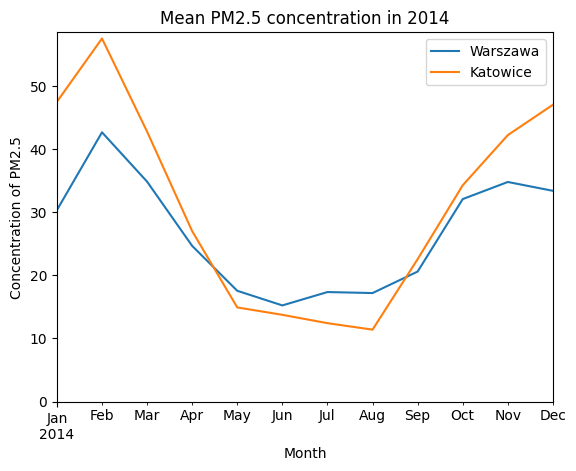

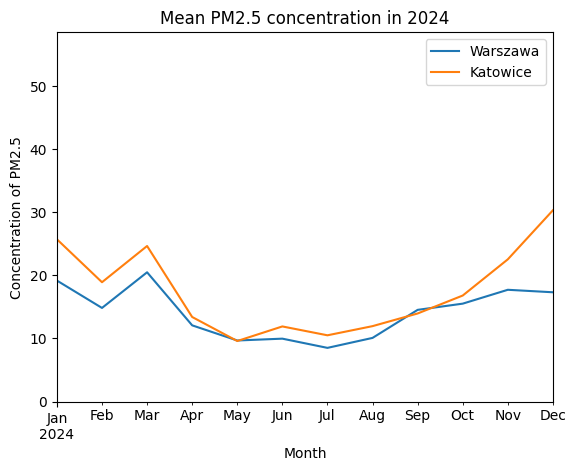

In [249]:
# Exercise 2
cities = ['Warszawa', 'Katowice']
years = [2014, 2024]
years_trend_cities(df, cities=cities, years=years)

There is 20


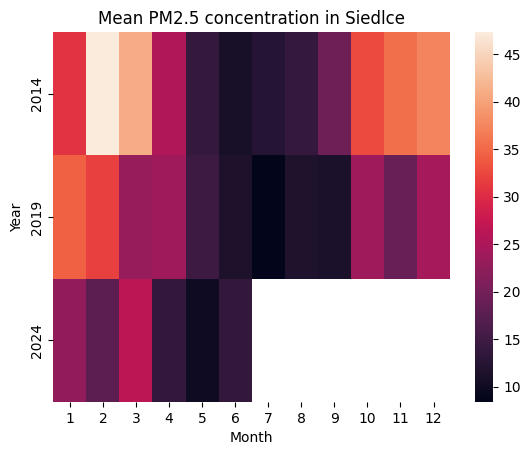

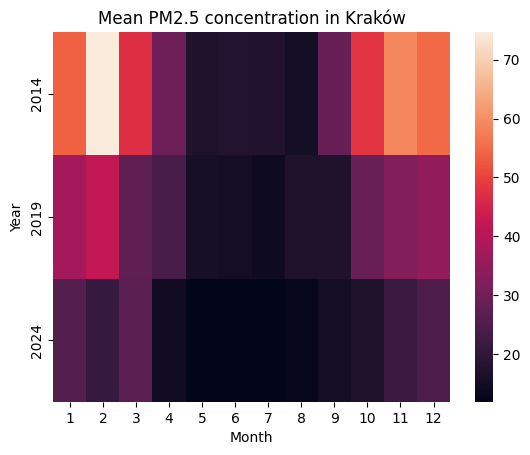

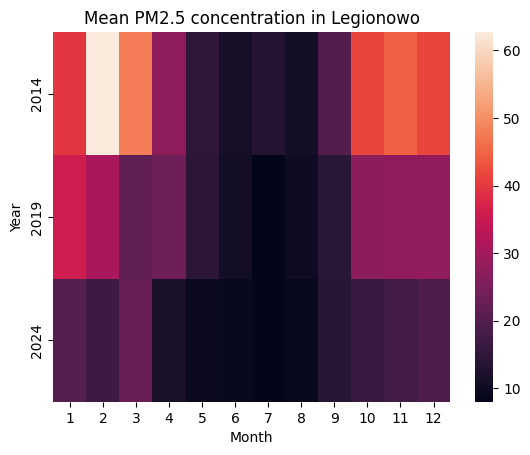

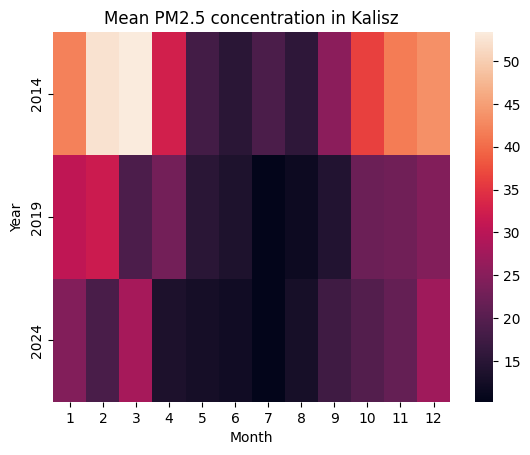

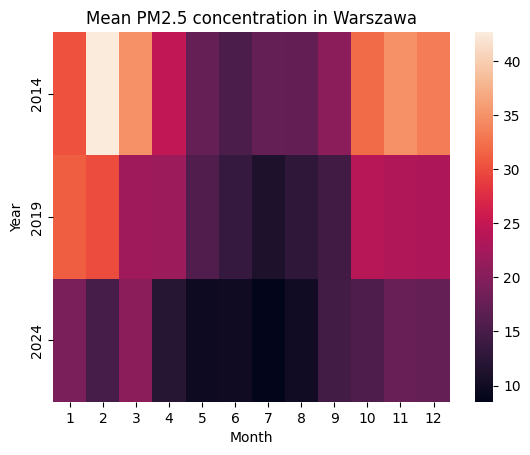

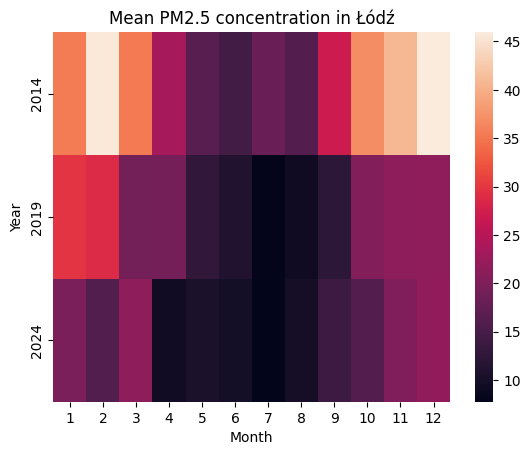

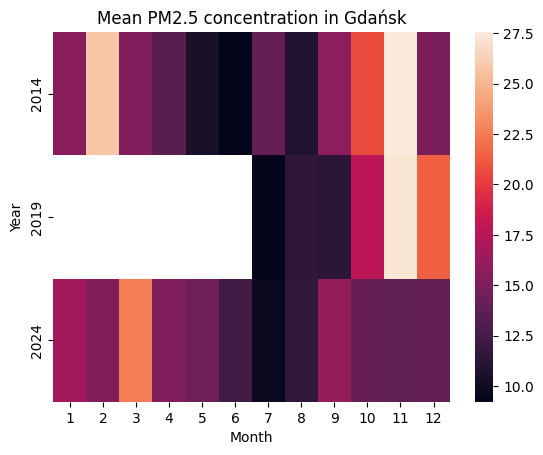

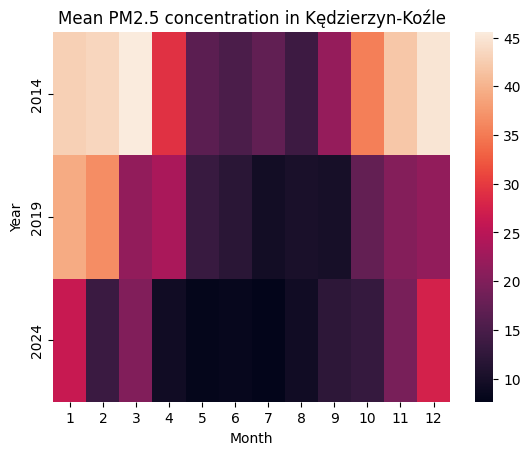

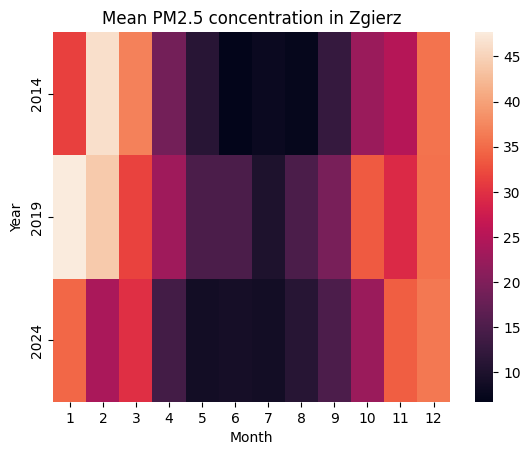

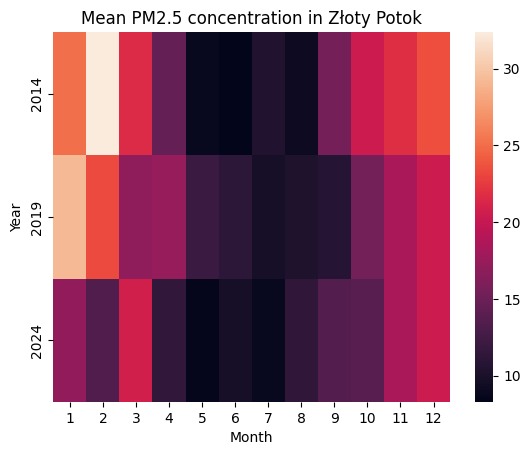

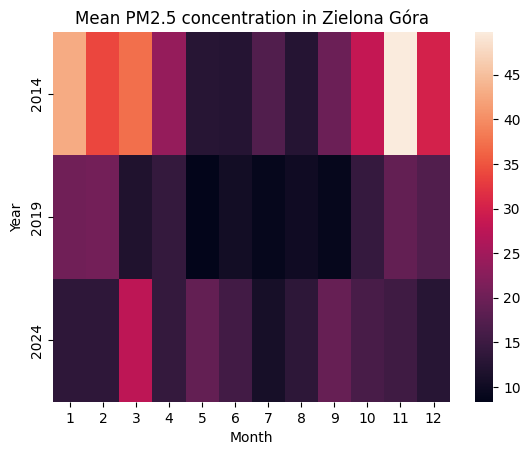

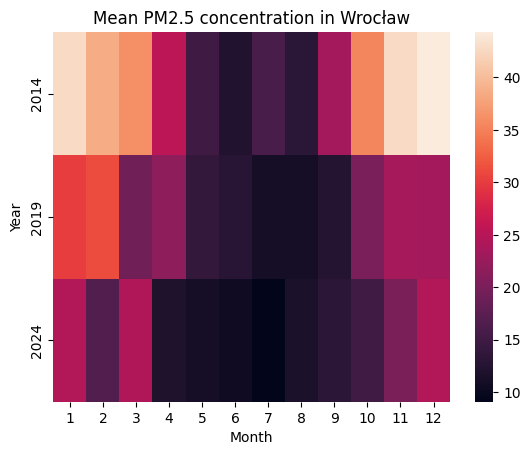

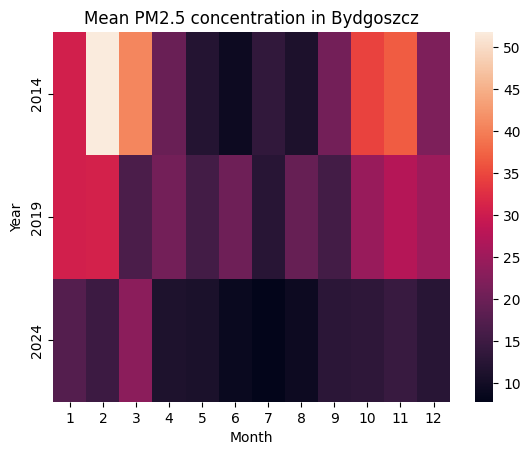

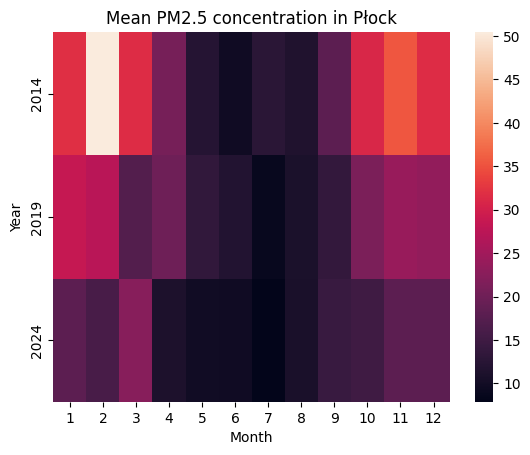

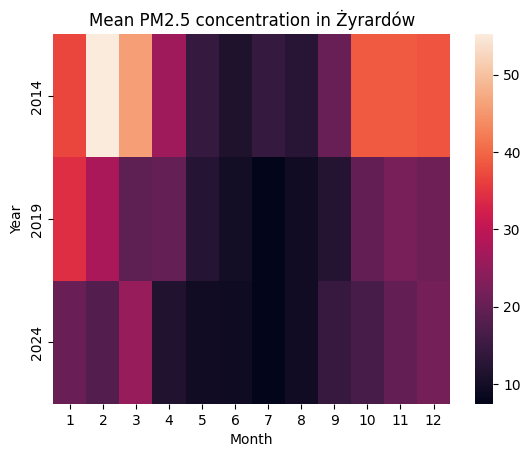

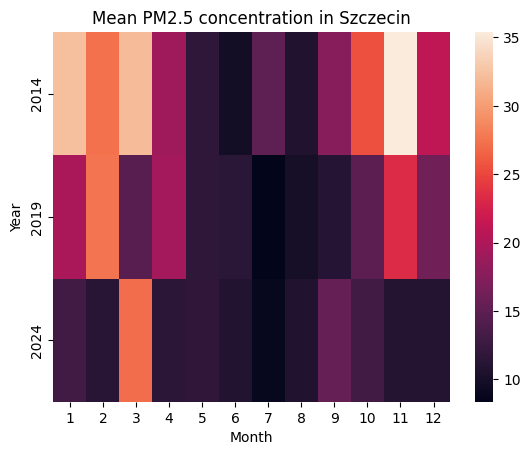

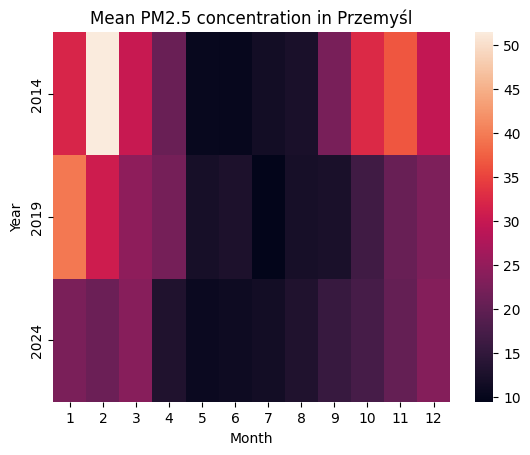

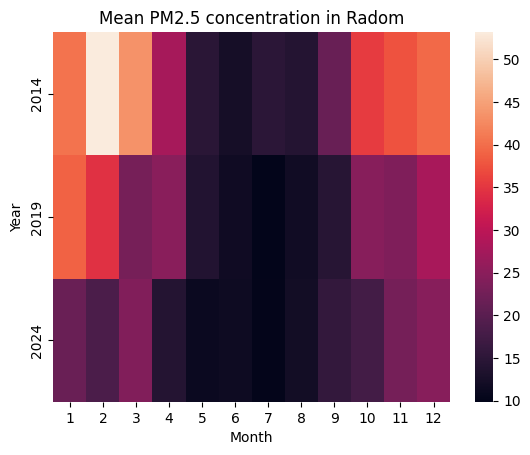

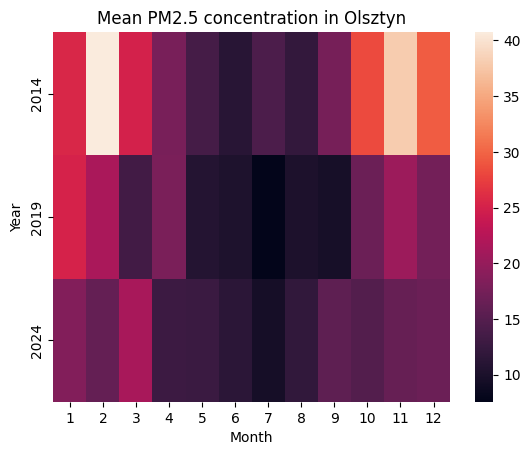

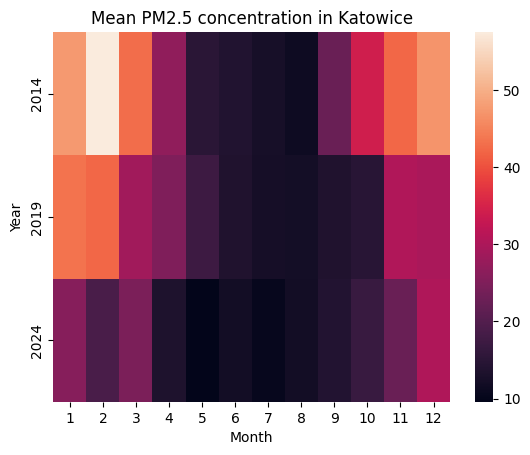

In [241]:
# Exercise 3
cities = ['Warszawa', 'Katowice']
years = [2014, 2019, 2024]
years_heatmaps_cities(df, cities='all', years=years)